In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
sym_org = generate_ring(20, 1, 2)


In [3]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


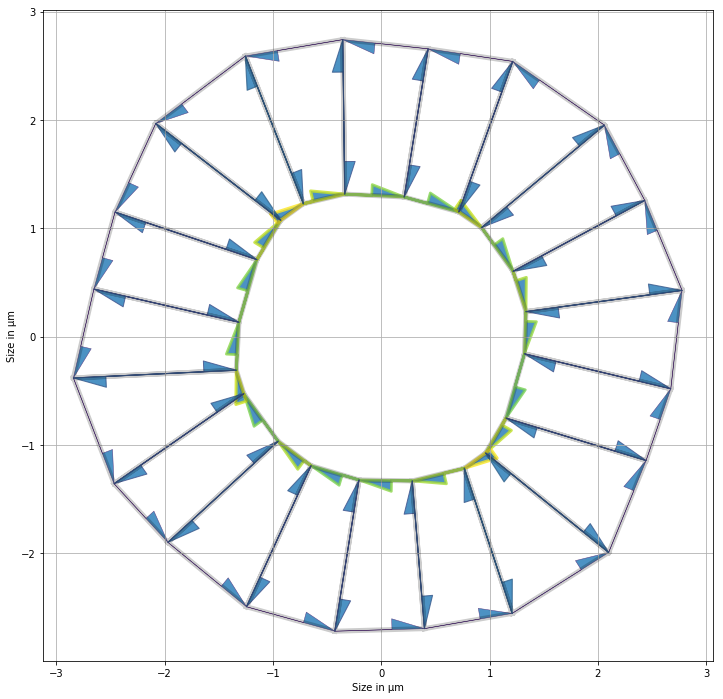

In [4]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo3 = create_organo(nf, r_in, r_out)

organo3.edge_df.loc[organo3.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo3.edge_df.loc[organo3.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo3.edge_df.loc[organo3.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo3.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo3.face_df.area

geom.update_all(organo3)
Solver.find_energy_min(organo3, geom, model)
print_tensions(organo3, organo3)

In [5]:
real_data = np.concatenate((organo3.edge_df.line_tension[:3*organo3.Nf],
                            organo3.face_df.prefered_area - organo3.face_df.area,
                            [organo3.settings['lumen_prefered_vol']-
                             organo3.settings['lumen_volume']]))
print(organo3.edge_df.line_tension, '\n',
      organo3.face_df.prefered_area - organo3.face_df.area)

edge
0     0.101
1     0.115
2     0.126
3     0.110
4     0.105
5     0.102
6     0.112
7     0.102
8     0.118
9     0.105
10    0.104
11    0.115
12    0.127
13    0.116
14    0.106
15    0.103
16    0.117
17    0.105
18    0.111
19    0.107
20    0.010
21    0.011
22    0.012
23    0.011
24    0.010
25    0.010
26    0.011
27    0.010
28    0.011
29    0.010
      ...  
50    0.030
51    0.035
52    0.040
53    0.035
54    0.030
55    0.030
56    0.035
57    0.030
58    0.035
59    0.030
60    0.030
61    0.035
62    0.040
63    0.035
64    0.030
65    0.030
66    0.035
67    0.030
68    0.035
69    0.030
70    0.030
71    0.035
72    0.040
73    0.035
74    0.030
75    0.030
76    0.035
77    0.030
78    0.035
79    0.030
Name: line_tension, Length: 80, dtype: float64 
 face
0     0.037466
1     0.042980
2     0.047452
3     0.041083
4     0.039120
5     0.037130
6     0.042399
7     0.037119
8     0.043188
9     0.038093
10    0.038654
11    0.042510
12    0.047137
13    0.042130

Computing the distance for different $\Lambda_{0,1}$

In [13]:
organo3.edge_df.line_tension[0]
list_dist = []
for t in np.linspace(0.05, 0.15, 1001):
    print(t)
    tmp_eptm = organo3.copy()
    tmp_eptm.edge_df.line_tension[0] = t
    Solver.find_energy_min(tmp_eptm, geom, model)
    list_dist.append(
        np.sum(np.linalg.norm(
            _distance(organo3, tmp_eptm),
            axis=1)))

0.05


/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.050100000000000006
0.0502
0.050300000000000004
0.0504
0.0505
0.050600000000000006
0.0507
0.050800000000000005
0.0509
0.051000000000000004
0.0511
0.0512
0.051300000000000005
0.0514
0.051500000000000004
0.0516
0.0517
0.051800000000000006
0.0519
0.052000000000000005
0.0521
0.0522
0.0523
0.0524
0.052500000000000005
0.0526
0.052700000000000004
0.0528
0.0529
0.053000000000000005
0.0531
0.053200000000000004
0.0533
0.0534
0.053500000000000006
0.0536
0.053700000000000005
0.0538
0.0539
0.054000000000000006
0.0541
0.054200000000000005
0.0543
0.054400000000000004
0.0545
0.0546
0.0547
0.0548
0.054900000000000004
0.055
0.0551
0.0552
0.0553
0.055400000000000005
0.0555
0.055600000000000004
0.0557
0.0558
0.055900000000000005
0.056
0.056100000000000004
0.0562
0.0563
0.056400000000000006
0.0565
0.056600000000000004
0.0567
0.0568
0.0569
0.057
0.057100000000000005
0.0572
0.057300000000000004
0.0574
0.0575
0.0576
0.0577
0.057800000000000004
0.0579
0.058
0.0581
0.0582
0.058300000000000005
0.0584
0.0585
0.0

0.13219999999999998
0.1323
0.1324
0.1325
0.1326
0.13269999999999998
0.1328
0.1329
0.133
0.1331
0.13319999999999999
0.1333
0.1334
0.1335
0.1336
0.13369999999999999
0.1338
0.1339
0.134
0.1341
0.13419999999999999
0.13429999999999997
0.1344
0.1345
0.1346
0.1347
0.13479999999999998
0.1349
0.135
0.1351
0.1352
0.13529999999999998
0.1354
0.1355
0.1356
0.1357
0.13579999999999998
0.1359
0.136
0.1361
0.1362
0.13629999999999998
0.1364
0.1365
0.1366
0.1367
0.13679999999999998
0.1369
0.137
0.1371
0.1372
0.13729999999999998
0.1374
0.1375
0.1376
0.1377
0.13779999999999998
0.1379
0.138
0.1381
0.1382
0.13829999999999998
0.1384
0.1385
0.1386
0.1387
0.13879999999999998
0.1389
0.139
0.1391
0.1392
0.13929999999999998
0.1394
0.1395
0.1396
0.1397
0.13979999999999998
0.1399
0.14
0.1401
0.1402
0.14029999999999998
0.1404
0.1405
0.1406
0.1407
0.14079999999999998
0.1409
0.14100000000000001
0.1411
0.1412
0.14129999999999998
0.1414
0.14150000000000001
0.1416
0.1417
0.14179999999999998
0.1419
0.14200000000000002
0.14

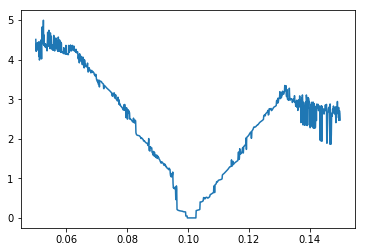

In [37]:
from matplotlib import pyplot as plt
plt.plot(np.linspace(0.05, 0.15, 1001), list_dist)